In [33]:
# to_save, to_load = False, True
session_file = "./tmp/Misc_ETV_extraction_coshgauss_417657237_KIC11761199_sec.ipynb.pkl"

# load/save the notebook session
# https://dill.readthedocs.io/en/latest/
# if True: 
#     import sys
#     if not "../.." in sys.path:  # for loading lightkurve_ext, etc.
#         sys.path.append("../..")
#     import dill
    
#     dill.load_module(session_file)
#     print(f"Notebook session loaded from  {session_file}")

# if True:  # save the notebook session
#     import dill
#     dill.dump_module(session_file)
#     print(f"Notebook session saved in {session_file}")


Notebook session saved in ./tmp/Misc_ETV_extraction_coshgauss_417657237_KIC11761199_sec.ipynb.pkl


In [2]:
import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
from astropy.time import Time
import astropy.units as u
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions

from importlib import reload

%matplotlib inline

In [3]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_seconds = 86400

## Looking for ETVs in TIC 417657237 / KIC 11761199 (secondary eclipses)

- signficiant apsidal motion, so the period of the secondary eclipses has to be fit separately here.


In [4]:
# define the plotting parameters

figsize = (8,4)

In [5]:
# import the data

# choose a TIC ID to analyze (we analyze non TESS portion heree0
ticid = 417657237
kicid = 11761199

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_kic{kicid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_kic{kicid}_etv_secondary.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../


sr = lk.search_lightcurve(f"KIC {kicid}")  # all long cadence data
# sr = lke.filter_by_priority(sr, author_priority=['Kepker'], exptime_priority=['long',])
# sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
with astropy.conf.set_temp("max_lines", -1):
    display(sr)
sr_kepler = sr
lcc_kepler = sr.download_all()
lc_kepler = lcc_kepler.stitch(
    # corrector_func=lambda lc: use_sap_flux(lc).normalize()
)
lc_kepler.time.format = "jd"  # changed time from BKJD to BJD, in case I want to accomodate other archival data (ASAS-SN, etc.)

len(lc_kepler)


#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,Kepler Quarter 01,2009,Kepler,1800,kplr011761199,0.0,EX
1,Kepler Quarter 02,2009,Kepler,1800,kplr011761199,0.0,EX
2,Kepler Quarter 03,2009,Kepler,1800,kplr011761199,0.0,EX
3,Kepler Quarter 04,2010,Kepler,1800,kplr011761199,0.0,EX
4,Kepler Quarter 05,2010,Kepler,1800,kplr011761199,0.0,EX
5,Kepler Quarter 06,2010,Kepler,1800,kplr011761199,0.0,EX
6,Kepler Quarter 07,2010,Kepler,1800,kplr011761199,0.0,EX
7,Kepler Quarter 08,2011,Kepler,1800,kplr011761199,0.0,EX
8,Kepler Quarter 09,2011,Kepler,1800,kplr011761199,0.0,EX


65031

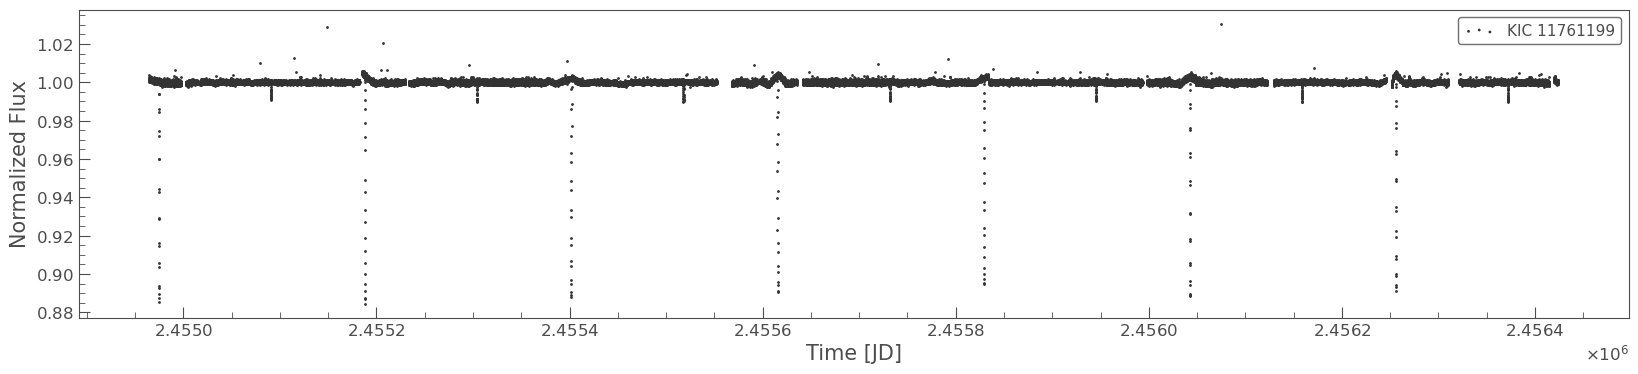

In [6]:
# visualize them , to ensure no eclipses overlap
import tic_plot as tplt
ax = tplt.scatter(lc_kepler, figsize=(20, 4));

In [7]:
sr = lk.search_lightcurve(f"TIC{ticid}")
sr = lke.filter_by_priority(sr, author_priority=['SPOC', 'TESS-SPOC', 'QLP'])
sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
with astropy.conf.set_temp("max_lines", -1):
    display(sr)
sr_tess = sr

lcc_tess = sr.download_all()

def use_sap_flux(lc):
    """Helper over select_flux("sap_flux") to ensure flux_err is populated for QLP case"""
    if lc.meta.get("AUTHOR") == "QLP":
        # select_flux("sap_flux") on QLP data will lead to nan flux_err
        # because QLP lc only has err on kspsap_flux / det_flux
        return lc
    else:
        return lc.select_flux("sap_flux")
lc_tess = lcc_tess.stitch(
    # corrector_func=lambda lc: use_sap_flux(lc).normalize()
)
lc_tess.time.format = "jd"  # changed time from BKJD to BJD, in case I want to accomodate other archival data (ASAS-SN, etc.)

len(lc_tess)


#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 74,2024,SPOC,120,417657237,0.0,G06085
1,TESS Sector 75,2024,SPOC,120,417657237,0.0,G06085
2,TESS Sector 80,2024,SPOC,120,417657237,0.0,G06085
3,TESS Sector 81,2024,SPOC,120,417657237,0.0,G06085
4,TESS Sector 82,2024,SPOC,120,417657237,0.0,G06085


93363

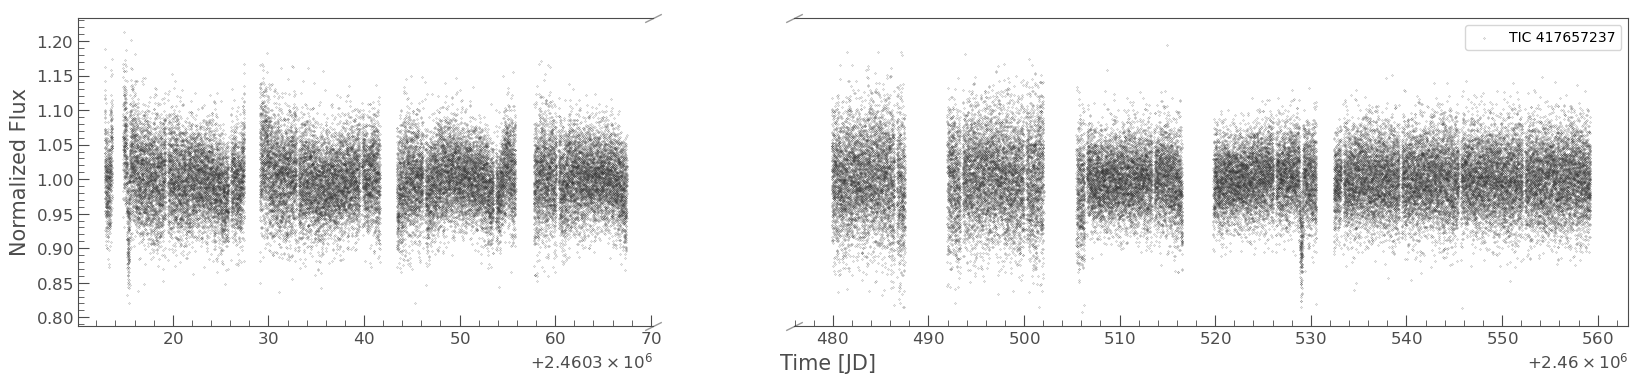

In [8]:
fig, axs = tplt.plot_skip_data_gap(lc_tess, figsize=(20, 4), s=0.1);

In [9]:
search_result = lke.stitch(lk.LightCurveCollection([lc_kepler, lc_tess]))

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)


158394

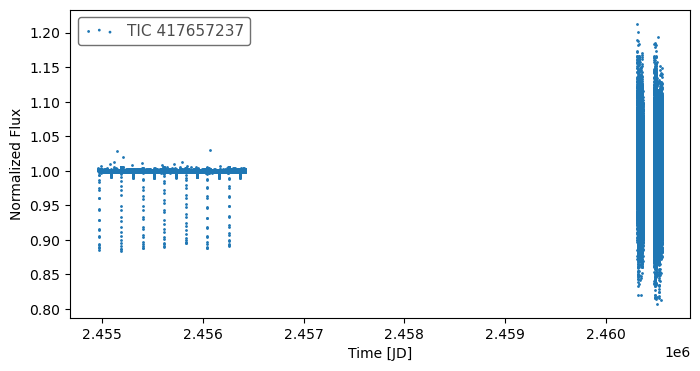

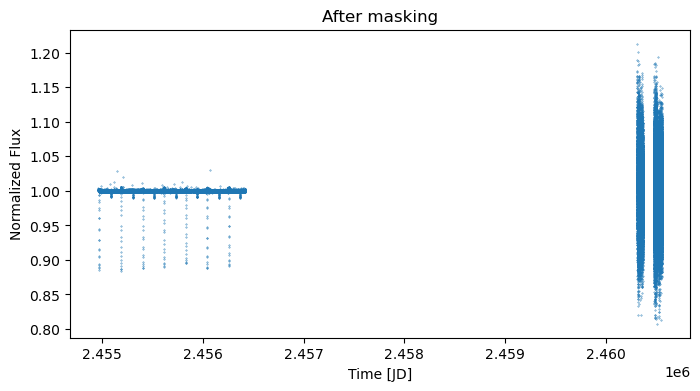

In [10]:
%matplotlib inline
# %matplotlib widget

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)

mask = time < 0  #( time > 54950) & (time < 54963)  #  truncate weird spikes at the beginning of Kepler data
# mask = flux < 0.85    # remove occasional outliers
# mask = (
#     ( flux < 0.95 ) | # remove occasional lone outliers
#     # cadences where scattered light effect is prevalent
#     ( (time > 2718)   & (time < 2744) )
# )

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=figsize).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [ ]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [ ]:
do_ls = False

if do_ls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg as lke_pg  # at ../../

    lc = lk.LightCurve(time=Time(time, format="btjd"), flux=flux, flux_err=fluxerr)
    lc.meta["LABEL"] = f"TIC {ticid}"
    pg = lc.to_periodogram(method="lombscargle",
                           # maximum_period=10,
                           # minimum_period=0.4,
                           # ls_method="fastchi2", nterms=2,
                           # oversample_factor=50,  # default: 5
                          )

    pg.show_properties();
    print(pg.period_at_max_power);

    ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=10);

    ax = pg.plot(view="frequency");  # frequency view
    ax.set_xlim(pg.frequency_at_max_power.value / 100 , pg.frequency_at_max_power.value * 10);

    ax = pg.plot(view="frequency", unit=u.microhertz, scale="log");

    axs, lcs = lke_pg.plot_lc_with_model(
        lc,
        pg,
        plot_lc=False, plot_model=False, plot_folded_model=True,
        also_return_lcs=True);


In [ ]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

In [12]:
tplt.plot_transit_interactive(search_result);

Output(layout=Layout(border_bottom='1px solid lightgray', border_left='1px solid lightgray', border_right='1px…

Output(layout=Layout(padding='1em'))

### Define epoch, period, duration

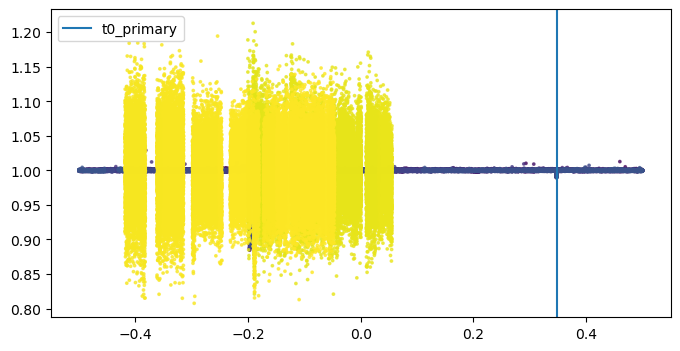

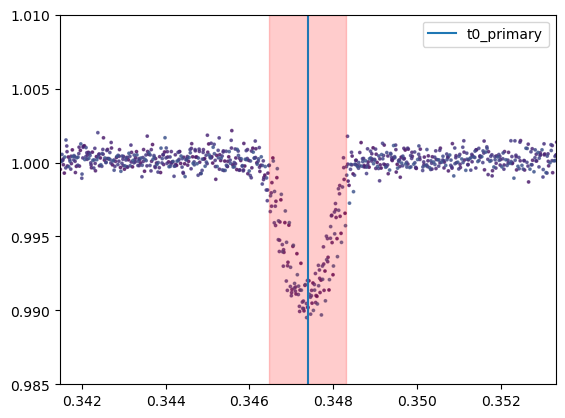

In [25]:
%matplotlib inline
# %matplotlib widget

# define the orbital period and the t0

# MCMC: p: 213.55426081600461 std_p: 0.000 4979947946541876 ; t0: 2455090.9719931437, std_t0: 0.0017686413127357488

# period = 213.555  # visual
period = 213.554  # MCMC

t0_primary = 2455091.0  # actually secondary, visual
t0_primary = 2455090.97  # actually secondary, MCMC
t0_secondary = None

duration_hr_primary =  9.4  # visual 
# duration_hr_secondary = 

# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
if t0_secondary is not None:
    t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

t0_for_plotting = 0  # keep 0 for plotting purposes
if t0_secondary is not None:
    t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.45  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period
plt.xlim(t1_p - 0.005, t4_p + 0.005);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
plt.ylim(0.985, 1.01);
plt.show()

if t0_secondary is not None:
    plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
    t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period
    plt.xlim(t1_s - 0.005, t4_s + 0.005);
    plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
    plt.legend();
    plt.ylim(0.985, 1.01);
    plt.show()

### Compare folded plots across sectors

In [ ]:
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_primary)
        lc_f = lc_f.truncate(-duration_hr_primary * 2 / 24, duration_hr_primary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0:
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around primary eclipses");
plt.tight_layout();

# ---
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_secondary)
        lc_f = lc_f.truncate(-duration_hr_secondary * 2 / 24, duration_hr_secondary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0:
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around secondary eclipses");
plt.tight_layout();

### Detrend (optional)

- detrended flux is in `flux_detrended`, and won't be used in subsequent work by default

In [ ]:
data["flux_original"] = data.flux  # save the original flux 

In [ ]:
# show data to visualize what's changed in each step below
data

In [ ]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

In [ ]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

In [ ]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period 
plt.xlim(t1_p - 0.025, t4_p + 0.025);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

if t0_secondary is not None:
    plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
    t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period 
    plt.xlim(t1_s - 0.025, t4_s + 0.025);
    plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
    plt.legend();
    # plt.ylim(0.975, 1.005);
    plt.show()

In [ ]:
# # Uncomment to use the detrended flux
# #
# print("Use deterended flux")
# data.flux = data.flux_detrended

### Now that the data is ready we can start 

- generally the clipped LC window is ***smaller*** than the eclipse duration, to avoid the complication of fitting ingress/egress.

In [26]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
# midpoint_p -= 0.004  # the offset is added back to t0_primary (& secondary above
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width_p = 5 * duration_hr_primary / 24 / period   # large window to account for ETV
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p / 2) & (data['phase'] < midpoint_p + window_width_p / 2) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


# too much apsiadal motion for secondary
if False and t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)

    window_width_s = 1.5 * duration_hr_secondary / 24 / period
    # window_width_s = 0.22
    print("window_width_s (phase):", window_width_s)

    data_secondary = data[(data['phase'] > midpoint_s - window_width_s / 2) & (data['phase'] < midpoint_s + window_width_s / 2) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V)
# t0 in normalixed phase
start_vals = [1.000, -0.009, midpoint_p, 0.00053, 1.18]
# start_vals_s = [1.0, -0.01, midpoint_s, 0.021, 0.9]

# -- -- -- -- -- -- -- -- --
# etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
etv_functions.plot_initial_guess_interactive(data_primary, ph_binned, flux_binned, err_binned, "midpoint_p", *start_vals)
if False and t0_secondary is not None:
    # etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)
    etv_functions.plot_initial_guess_interactive(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, "midpoint_s", *start_vals_s)

print("Start params for  fitting period with MCMC on df_primary:")
print(f"[{start_vals[0]}, {start_vals[1]}, {t0_primary}, {start_vals[3]}, {start_vals[4]}, {period}],");

Primary:   2455090.97 0.34738754600902977
window_width_p (phase): 0.009170202072231536


Output(layout=Layout(padding='1em 0px'), outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Fig…

Output(layout=Layout(padding='1em'), outputs=({'name': 'stdout', 'text': '[1.0, -0.009, midpoint_p, 0.00053, 1…

Start params for  fitting period with MCMC on df_primary:
[1.0, -0.009, 2455090.97, 0.00053, 1.18, 213.554],


#### Refine period

In [ ]:
if False:
    # Export the data around primary eclipses, for period analysis outside of notebook
    data_primary[["time", "flux", "err"]].to_csv(f"tmp/data_primary_tic{ticid}_kic{kicid}.csv", index=False)

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 2000/2000 [01:30<00:00, 22.10it/s]
The chain is shorter than 20 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/20 = 100;
tau: [ 42.28499256 123.58343215 129.55836364 134.93740561 158.53848754
  67.37627732]


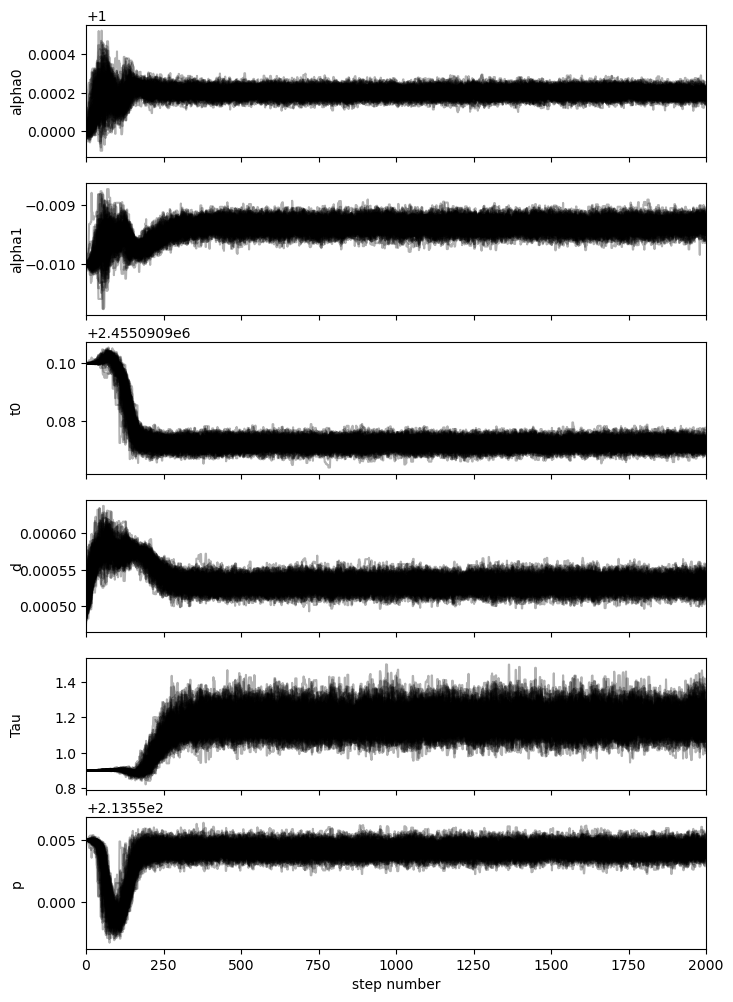

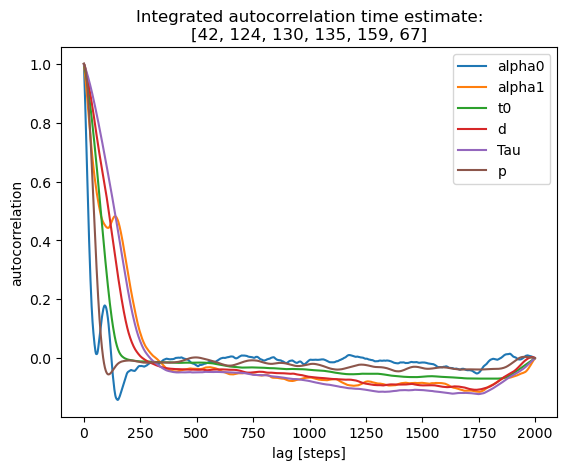

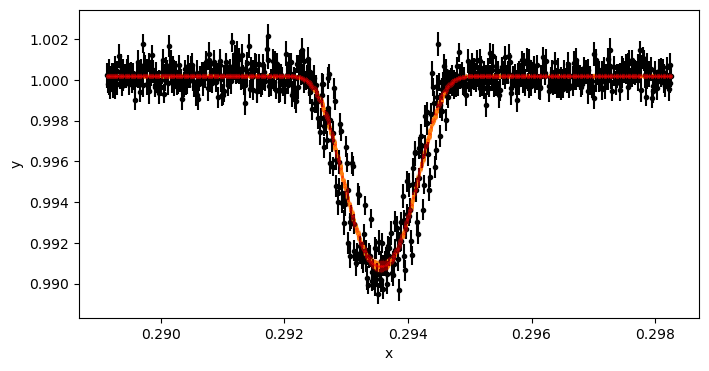

mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.000201766280975, -0.009341466712100774, 2455090.9719931437, 0.000530056343130858, 1.1813764293980045, 213.55426081600461
std_p: 0.0004979947946541876 ; std_t0: 0.0017686413127357488


In [24]:
# use MCMC to refine the period

use_mcmc_to_fit_period = True


if use_mcmc_to_fit_period:
    import etv_functions_with_period as etvp

    etv_functions.enable_info_log_for_jupyter()

    # MCMC result
    mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats = etvp.run_mcmc_initial_fit_p(
        data_primary[:],
        [1.0, -0.01, 2455091.0, 0.0005, 0.9, 213.555],
        # nruns=20, discard=1, # for a sanity test,  to ensure the initial guess is not way off.
        nruns=2000, discard=600,
        # nruns=5000, discard=1000,
        autocorr_time_kwargs=dict(tol=20),  # the emcee defaults tol=50 seems to be too strict for our use case, tol of ~10 - 20 seems to be sufficient
        pool=-2,
        plot_chains=True,
        plot_autocorrelation=True,
        plot=True,
        also_return_stats=True,
    )
    print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
    print("std_p:", fit_params_p_stats["std_p"], "; std_t0:", fit_params_p_stats['std_t0'])
    !$NOTIFY_CMD "Fitting period done."

In [ ]:
# AoV from VStar on df_primary

# _lc = lk.LightCurve(time=Time(data_primary.time, format="jd", scale="tdb"), flux=data_primary.flux, flux_err=data_primary.err)
# for p in [213.6182, 213.6185, 213.6193, 213.6192, 213.6186]:
#     _lc_f = _lc.fold(epoch_time=t0_primary, period=p);
#     ax = tplt.scatter(_lc_f, c=_lc_f.time_original.value);
#     ax.set_title(f"P: {_lc_f.period}");

In [ ]:
# VStar DC DFT for period 213.5 - 213.7, resolution=0.0001

# _lc = lk.LightCurve(time=Time(data_primary.time, format="jd", scale="tdb"), flux=data_primary.flux, flux_err=data_primary.err)
# for p in [213.6318, 213.6320, 213.6317, 213.6322, 213.6319]:
#     _lc_f = _lc.fold(epoch_time=t0_primary, period=p);
#     ax = tplt.scatter(_lc_f, c=_lc_f.time_original.value);
#     ax.set_title(f"P: {_lc_f.period}");

alpha0: 1.000201313680734 +- 2.462656034352194e-05
alpha1: -0.009352839755534711 +- 0.00011210898093758804
t0: 2455090.971783321 +- 0.0018910193068597423
d: 0.0005278730658578566 +- 9.984893357047702e-06
Tau: 1.172735806820756 +- 0.059018921177922935
p: 213.55433570899342 +- 0.0005166758126213125


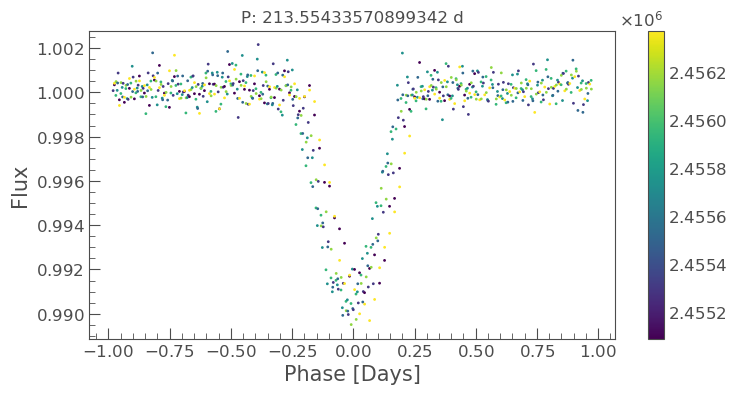

In [31]:
# use scipy.curve_fit
import inspect
from scipy.optimize import curve_fit

def get_model_param_names(model_func):
    # skip the first parameter, which is x:
    return list(inspect.signature(model_func).parameters.keys())[1:]


# Use curve_fit to find optimal parameters
# popt contains the optimal parameters (a, b)
# pcov contains the estimated covariance of popt
popt, pcov = curve_fit(
    etvp.coshgauss_model_fit_p, 
    data_primary.time, data_primary.flux, sigma=data_primary.err, absolute_sigma=True,
    p0=[1.0, -0.009, 2455090.97, 0.00053, 1.18, 213.554],  # initial guess
    nan_policy="omit",
)

perr = np.sqrt(np.diag(pcov))  # convert covaraince matrix to uncertaintiy in standard error
for _n, _v, _e in zip(get_model_param_names(etvp.coshgauss_model_fit_p), popt, perr):
    print(f"{_n}: {_v} +- {_e}")

_lc = lk.LightCurve(time=Time(data_primary.time, format="jd", scale="tdb"), flux=data_primary.flux, flux_err=data_primary.err)
_lc_f = _lc.fold(epoch_time=popt[2] , period=popt[5] );
ax = tplt.scatter(_lc_f, c=_lc_f.time_original.value);
ax.set_title(f"P: {_lc_f.period}");

#### Initial Fit model once period is fixed

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 3000/3000 [02:48<00:00, 17.75it/s]


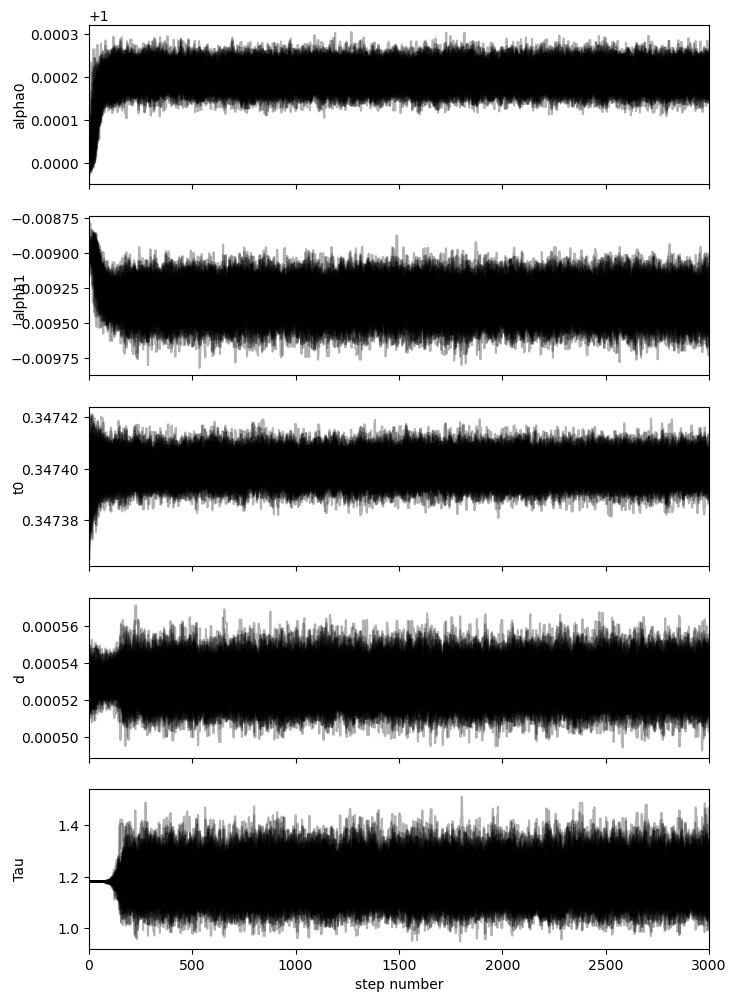

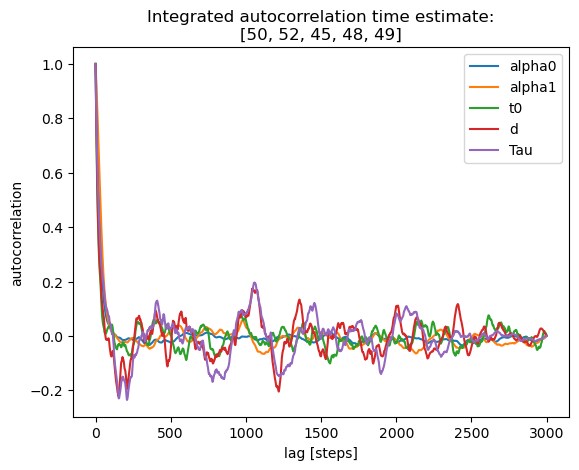

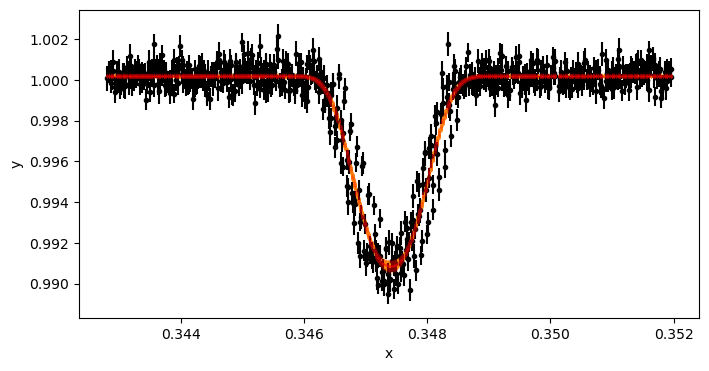

In [30]:
# run the initial model fit using MCMC for the primary and secondary eclipses
run_init_fit = True

if run_init_fit:
    etv_functions.enable_info_log_for_jupyter()
    
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, fit_params_stats = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns=3000, discard=600, autocorr_time_kwargs=dict(tol=20), pool=-2, plot_chains=True,  plot_autocorrelation=True, plot=True, also_return_stats=True)
    if False and t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, fit_params_s_stats = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns=3000, discard=600, autocorr_time_kwargs=dict(tol=20), pool=-2, plot_chains=True,  plot_autocorrelation=True, plot=True, also_return_stats=True)
    !$NOTIFY_CMD "Initial fit done"

In [ ]:
if not run_init_fit:  # case init fit has been previously saved and to be reussed
    print("Use pre-defined inital model params:")
    # initial fit params from Kepler data
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = = 1.0027597210791332, -0.10338895075180066, 0.24460015633886242, 0.0005449638299478545, 0.9841462832883583
    # mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 


    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau])
    # etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])

In [ ]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if False and t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

In [ ]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

In [ ]:
tr_index = range(0,n_transits)

for i in np.concatenate( (tr_index[0:3], tr_index[-3:]) ): 
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux)
    yerr = np.array(data_primary.err)

    print (t0_primary, period, transit_time)

    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period)))

    x = np.array(x[mask])
    y = np.array(y[mask])
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()


if False and t0_secondary is not None:
    for i in np.concatenate( (tr_index[0:3], tr_index[-3:]) ): 
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux)
        yerr = np.array(data_secondary.err)

        print (t0_secondary, period, transit_time)

        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period)))

        x = np.array(x[mask])
        y = np.array(y[mask])
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

### Fit individual eclipses

In [ ]:
longest_cadence

In [ ]:
# Provide a warning if the expected number of data points per clipped LC is smaller than the default minimum `min_number_data` (20)
# longest_cadence = np.max(sr.exptime)
longest_cadence = 30 * u.min
est_number_data_primary   = int(window_width_p  * period * 24 / longest_cadence.to(u.hr).value)
print(f"Expected num of data points of a clipped LC in longest cadence ({longest_cadence}) for primary: {est_number_data_primary}")
if est_number_data_primary < 20:
    display(HTML("<span style='background-color: rgba(255, 0, 0, 0.7); padding-left: 1ch; padding-right: 1ch;'>WARN:</span> num of data points for a clipped LC (primary) < 20"))

if False and t0_secondary is not None:
    est_number_data_secondary = int(window_width_s  * period * 24 / longest_cadence.to(u.hr).value)
    print(f"Expected num of data points of a clipped LC in longest cadence ({longest_cadence}) for secondary:  {est_number_data_secondary}")
    if est_number_data_secondary < 20:
        display(HTML("<span style='background-color: rgba(255, 0, 0, 0.7); padding-left: 1ch; padding-right: 1ch;'>WARN:</span> num of data points for a clipped LC (secondary) < 20"))

In [ ]:
%matplotlib inline

# from importlib import reload
# reload(etv_functions)

print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path,
                               # min_number_data=20, # to fit 30 min cadence data
                              )
!$NOTIFY_CMD "Individual primary eclipses fit done"


In [ ]:
# ---

%matplotlib inline

if False and t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s,
                                   min_number_data=10, # to fit 30 min cadence data
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses fit done"
else:
    print("No secondary eclipses defined. No-Op.")

## ETV O-C plot

In [ ]:
def get_time_span_isodate(df):
    start, end = df.iloc[0]['midpoint'], df.iloc[-1]['midpoint']
    start = Time(start, format="jd").to_value("iso", subfmt="date")
    end = Time (end,format="jd").to_value("iso", subfmt="date")
    return f"{start} - {end}"

In [ ]:
%matplotlib inline
# %matplotlib widget


title_suffix = "eclipse timing variation"

#plot the extracted transit times to check for ETVs

num_rows = 2 if False and t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary_all = in_df_primary  # in case filtering is helpful

# in_df_primary = in_df_primary[(0 < in_df_primary.shift_mins) & (in_df_primary.shift_mins < 2)]  # filter out outliers from visual inspection
# print(f"Note: {len(in_df_primary_all) - len(in_df_primary)} data points in df_primary filtered out as outliers.")

# axs[0].plot(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              lw = 1, color = 'crimson', )
# axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
             lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

# if False:
if False and t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    in_df_secondary_all = in_df_secondary  # in case filtering is helpful

    # in_df_secondary = in_df_secondary[(0 < in_df_secondary.shift_mins) & (in_df_secondary.shift_mins < 2)]  # filter out outliers from visual inspection
    # print(f"Note: {len(in_df_secondary_all) - len(in_df_secondary)} data points in in_df_secondary filtered as outliers.")

    # axs[1].plot(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              lw = 1, color = 'navy', )
    # axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
else:
    in_df_secondary = None

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
# use KID as it's the name in VSX
axs[0].set_title(f"KID {kicid}, {title_suffix}\nP: {period} d ; epoch: HJD {t0_primary} \ntimespan: ~ {get_time_span_isodate(in_df_primary)}", fontsize=14)

plt.subplots_adjust(hspace=0.05)
# [ax.set_ylim(-7, 4) for ax in axs]  # use a consistent y-scale for both Kepler and TESS (not shown) data 
plt.show()

In [ ]:
# another waty to visualize the change in period
in_df_primary["gap"] = np.concatenate(([np.nan], np.diff(in_df_primary.midpoint)))
in_df_primary[["midpoint", "gap"]].style.format({"midpoint": "{:.2f}"})

In [ ]:
# # to help to filter out valeus with huge error
# ax = in_df_primary_all.std_mins.hist(bins=100)
# ax.set_xscale("log")
# ax.set_yscale("log")
# plt.show()

# ax = in_df_secondary_all.std_mins.hist(bins=100)
# ax.set_xscale("log")
# ax.set_yscale("log")
# plt.show()

### O-C Plot, Zoom In

In [ ]:
%matplotlib inline
# %matplotlib widget

zoom_ranges = [
    # (1600, 1800),
]

def tweak_axs_list(axs_list):
    # axs_list[0][1].set_ylim(-20, 30);
    # axs_list[1][0].set_ylim(None, 0.5);
    # axs_list[1][1].set_ylim(-5.5, 2);

    # ax = axs_list[0][0]
    # ax.set_title(f"{ax.get_title()} (2min cadence)")
    # ax = axs_list[1][0]
    # ax.set_title(f"{ax.get_title()} (2min cadence)")

    pass


def plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges):
    axs_list = []
    for zoom_start, zoom_end in zoom_ranges:
        num_rows = 2 if t0_secondary is not None else 1
        figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5

        fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
        if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
            axs = [axs]

        df_zoom = in_df_primary[(in_df_primary['epoch'] > zoom_start) & (in_df_primary['epoch'] < zoom_end)]

        # axs[0].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
        #                marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
        axs[0].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

        if in_df_secondary is not None:
            df_zoom = in_df_secondary[(in_df_secondary['epoch'] > zoom_start) & (in_df_secondary['epoch'] < zoom_end)]

            # axs[1].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
            #                marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
            axs[1].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                            lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );

        for ax in axs:
            ax.set_ylabel("O - C (minutes)")
            ax.legend();

        axs[-1].set_xlabel("Time (BTJD)")
        axs[0].set_title(f"TIC {ticid}, {title_suffix}", fontsize=14)

        plt.subplots_adjust(hspace=0.05)
        axs_list.append(axs)
    return axs_list


axs_list = plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges)
tweak_axs_list(axs_list);

## make a periodogram 

In [ ]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()

fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(1/frequency, power, label = 'primary')

if False and t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
    plt.plot(1/frequency_s, power_s, label = 'secondary')

plt.xlabel("period")

plt.legend()
# plt.xlim(0, 3000)
plt.show()


if True:
    fig, ax = plt.subplots(figsize=(8, 4))

    plt.plot(1/frequency, power, label = 'primary')

    if False and t0_secondary is not None:
        plt.plot(1/frequency_s, power_s, label = 'secondary')

    plt.xlabel("period")

    plt.legend()
    plt.xlim(0, 15000)
    plt.show()



## O-C plot, folded

- for periodic trend in O-C

In [ ]:
def truncate_freq_power_to_period_range(freq, power, period_min, period_max):
    f, p = freq, power
    if period_min is not None:
        f, p = f[f < 1 / period_min], p[f < 1 / period_min]
    if period_max is not None:
        f, p = f[f > 1 / period_max], p[f >  1 / period_max]
    return f, p


def plot_oc_folded(period_min=None, period_max=None, period_min_s=None, period_max_s=None, period=None, period_s=None):

    if period is None:
        _f, _p = truncate_freq_power_to_period_range(frequency, power, period_min, period_max)
        period = 1 / _f[np.argmax(_p)]
    phase_oc = etv_functions.phase_data(in_df_primary.epoch, 0, period)

    fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y * 1.1), sharex=False)
    if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
        axs = [axs]
    
    axs[0].scatter(phase_oc, in_df_primary.shift_mins, marker = 'o', s=12**2, c=in_df_primary.epoch);
    axs[0].errorbar(phase_oc, in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
                    lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'None', label="primary")
    axs[0].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period:.4f} d", fontsize=14)

    if False and in_df_secondary is not None:
        if period_s is None:
            _f, _p = truncate_freq_power_to_period_range(frequency_s, power_s, period_min_s, period_max_s)
            period_s= 1 / _f[np.argmax(_p)]
        phase_oc_s = etv_functions.phase_data(in_df_secondary.epoch, 0, period_s)
        axs[1].scatter(phase_oc_s, in_df_secondary.shift_mins, marker = 'o',  s=12**2, c=in_df_secondary.epoch);
        axs[1].errorbar(phase_oc_s, in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color='None', ecolor='navy', markeredgecolor = 'None', label="secondary" );
        axs[1].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period_s:.4f} d", fontsize=14)

    for ax in axs:
        ax.set_ylabel("O - C (minutes)")
        ax.set_xlabel("Phase (Normalized)")
        ax.legend();
    plt.subplots_adjust(hspace=0.4)
    return axs

In [ ]:
%matplotlib inline
# %matplotlib widget

if True:  # plot O-C periodic trend by folding with a period (from LS Periodogram by default)
    def tweak_axs(axs):
        pass

    axs = plot_oc_folded(
        period_min=20, period_max=None,
        # period_min_s=20, period_max_s=None
    )
    axs = plot_oc_folded(
        period_min=6200, period_max=None,
        # period_min_s=20, period_max_s=None
    )
    axs = plot_oc_folded(
        period_min=None, period_max=6000,
        # period_min_s=20, period_max_s=None
    )
    tweak_axs(axs)

## Results Summary

In [ ]:
# FILL-IN the ETV results / comments
has_etv = "Y"
comments = "O-C suggests non-linear change. The O-C period is uncertain but easily 1000+ days. Apsidal motion seen in secondary eclipses"

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if False and t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True,
))

In [ ]:
# --- SuperWASP
from types import SimpleNamespace
# reload(etv_functions)

etv_out_str = "number,epoch,mean_alpha0,mean_alpha1,t0,stdv_t0,mean_d,mean_Tau\n"

ts = lc_s.time[0].value
telapsed = lc_s.time[-1].value - lc_s.time[0].value
num_chunks = 1
tchunk = int(telapsed / num_chunks)  # some data will be omitted at the end
print(f"Split the data over {telapsed:.1f} d into {num_chunks} chunks, each chunk of {tchunk} d")
for i in range(0, num_chunks):
    lc = lc_s.truncate(ts + tchunk * i, ts + tchunk * (i+1))
    lc_f = lc.fold(epoch_time=t0_primary, period=period, normalize_phase=True)
    lc_f = lc_f.truncate(-window_width_p / 2, window_width_p / 2)
    if len(lc_f) < 1:
        continue
    # ax = tplt.scatter(lc_f); ax.set_title(f"{lc_f.time_original.format.upper()} {lc_f.time_original.min().value:.2f} - {lc_f.time_original.max().value:.2f}"); continue;  # uncomment to just visualize the LC chunks

    # convert lc to the form needed by fit etv_functions
    lc_f_data = SimpleNamespace(time=lc_f.time_original.value, phase=lc_f.time.value, flux=np.array(lc_f.flux.value), err=np.array(lc_f.flux_err.value))

    res = etv_functions.run_mcmc_individual_fit(
        lc_f_data, 
        # use fixed d, Tau, and fit alpha0, alpha1, t0
        [mean_alpha0, mean_alpha1, 0, mean_d, mean_Tau],  # pass 0 as mean_t0, as the LC has been folded with t0 as midpoint
        # nruns=10000, discard=1000,
        nruns=3000, discard=1000,
        # nruns=1000, discard=400,
        # nruns=20, discard=1,
        pool=None,         
        plot_chains=i == 0,
        plot=True, 
    )
    _alpha0, _alpha1, _t0, _stdv_t0 = res
    _t = np.mean(lc_f_data.time)  # approximate transit time 
    print(i, _t, *res, f"({len(lc_f_data.time)})")
    etv_out_str += ",".join([str(s) for s in [i, _t, _alpha0, _alpha1, _t0, _stdv_t0, mean_d, mean_Tau]])
    etv_out_str += "\n"
    

print("")
print(etv_out_str)

In [ ]:
# --- ASAS-SN V
from types import SimpleNamespace
# reload(etv_functions)

etv_out_str = "number,epoch,mean_alpha0,mean_alpha1,t0,stdv_t0,mean_d,mean_Tau\n"

ts = lc_av.time[0].value
telapsed = lc_av.time[-1].value - lc_av.time[0].value
num_chunks = 1
tchunk = int(telapsed / num_chunks)  # some data will be omitted at the end
print(f"Split the data over {telapsed:.1f} d into {num_chunks} chunks, each chunk of {tchunk} d")
for i in range(0, num_chunks):
    lc = lc_av.truncate(ts + tchunk * i, ts + tchunk * (i+1))
    lc_f = lc.fold(epoch_time=t0_primary, period=period, normalize_phase=True)
    lc_f = lc_f.truncate(-window_width_p / 2, window_width_p / 2)
    if len(lc_f) < 1:
        continue
    # ax = tplt.scatter(lc_f); ax.set_title(f"{lc_f.time_original.format.upper()} {lc_f.time_original.min().value:.2f} - {lc_f.time_original.max().value:.2f}"); continue;  # uncomment to just visualize the LC chunks

    # convert lc to the form needed by fit etv_functions
    lc_f_data = SimpleNamespace(time=lc_f.time_original.value, phase=lc_f.time.value, flux=np.array(lc_f.flux.value), err=np.array(lc_f.flux_err.value))

    res = etv_functions.run_mcmc_individual_fit(
        lc_f_data, 
        # use fixed d, Tau, and fit alpha0, alpha1, t0
        [mean_alpha0, mean_alpha1, 0, mean_d, mean_Tau],  # pass 0 as mean_t0, as the LC has been folded with t0 as midpoint
        # nruns=10000, discard=1000,
        nruns=3000, discard=1000,
        # nruns=1000, discard=400,
        # nruns=20, discard=1,
        pool=None,         
        plot_chains=i == 0,
        plot=True, 
    )
    _alpha0, _alpha1, _t0, _stdv_t0 = res
    _t = np.mean(lc_f_data.time)  # approximate transit time 
    print(i, _t, *res, f"({len(lc_f_data.time)})")
    etv_out_str += ",".join([str(s) for s in [i, _t, _alpha0, _alpha1, _t0, _stdv_t0, mean_d, mean_Tau]])
    etv_out_str += "\n"
    

print("")
print(etv_out_str)

In [ ]:
# --- ASAS-SN g
from types import SimpleNamespace
# reload(etv_functions)

etv_out_str = "number,epoch,mean_alpha0,mean_alpha1,t0,stdv_t0,mean_d,mean_Tau\n"

ts = lc_ag.time[0].value
telapsed = lc_ag.time[-1].value - lc_ag.time[0].value
num_chunks = 2  # 3  # 5
tchunk = int(telapsed / num_chunks)  # some data will be omitted at the end
print(f"Split the data over {telapsed:.1f} d into {num_chunks} chunks, each chunk of {tchunk} d")
for i in range(0, num_chunks):
    lc = lc_ag.truncate(ts + tchunk * i, ts + tchunk * (i+1))
    lc_f = lc.fold(epoch_time=t0_primary, period=period, normalize_phase=True)
    lc_f = lc_f.truncate(-window_width_p / 2, window_width_p / 2)
    if len(lc_f) < 1:
        continue
    # ax = tplt.scatter(lc_f); ax.set_title(f"{lc_f.time_original.format.upper()} {lc_f.time_original.min().value:.2f} - {lc_f.time_original.max().value:.2f}"); continue;  # uncomment to just visualize the LC chunks

    # convert lc to the form needed by fit etv_functions
    lc_f_data = SimpleNamespace(time=lc_f.time_original.value, phase=lc_f.time.value, flux=np.array(lc_f.flux.value), err=np.array(lc_f.flux_err.value))

    res = etv_functions.run_mcmc_individual_fit(
        lc_f_data, 
        # use fixed d, Tau, and fit alpha0, alpha1, t0
        [mean_alpha0, mean_alpha1, 0, mean_d, mean_Tau],  # pass 0 as mean_t0, as the LC has been folded with t0 as midpoint
        # nruns=10000, discard=1000,
        nruns=3000, discard=1000,
        # nruns=1000, discard=400,
        # nruns=20, discard=1,
        pool=None,         
        plot_chains=i == 0,
        plot=True, 
    )
    _alpha0, _alpha1, _t0, _stdv_t0 = res
    _t = np.mean(lc_f_data.time)  # approximate transit time 
    print(i, _t, *res, f"({len(lc_f_data.time)})")
    etv_out_str += ",".join([str(s) for s in [i, _t, _alpha0, _alpha1, _t0, _stdv_t0, mean_d, mean_Tau]])
    etv_out_str += "\n"
    

print("")
print(etv_out_str)